<h1> 1. Exploring natality dataset </h1>

This notebook illustrates:
<ol>
<li> Exploring a BigQuery dataset using Datalab
</ol>

In [1]:
BUCKET = 'qwiklabs-gcp-02-b249231a9d6f'   
PROJECT = 'qwiklabs-gcp-02-b249231a9d6f'     
REGION = 'us-central1'              

In [2]:
import os

os.environ['BUCKET'] = BUCKET
os.environ['PROJECT'] = PROJECT
os.environ['REGION'] = REGION

In [3]:
%%bash
if ! gsutil ls | grep -q gs://${BUCKET}/; then
  gsutil mb -l ${REGION} gs://${BUCKET}
fi

<h2> Explore data </h2>

The data is natality data (record of births in the US). My goal is to predict the baby's weight given a number of factors about the pregnancy and the baby's mother.  Later, we will want to split the data into training and eval datasets. The hash of the year-month will be used for that -- this way, twins born on the same day won't end up in different cuts of the data.

In [4]:
# Create SQL query using natality data after the year 2000

query = """
SELECT
  weight_pounds,
  is_male,
  mother_age,
  plurality,
  gestation_weeks,
  FARM_FINGERPRINT(CONCAT(CAST(YEAR AS STRING), CAST(month AS STRING))) AS hashmonth
FROM
  publicdata.samples.natality
WHERE year > 2000
"""

In [5]:
# Call BigQuery and examine in dataframe

from google.cloud import bigquery

df = bigquery.Client().query(query + " LIMIT 100").to_dataframe()
df.head()

,weight_pounds,is_male,mother_age,plurality,gestation_weeks,hashmonth
0,7.063611,True,32,1,37.0,7108882242435606404
1,4.687028,True,30,3,33.0,-7170969733900686954
2,7.561856,True,20,1,39.0,6392072535155213407
3,7.561856,True,31,1,37.0,-2126480030009879160
4,7.312733,True,32,1,40.0,3408502330831153141


## Lab Task #1
Using the above code as an example, write a query to find the unique values for each of the columns and the count of those values for babies born after the year 2000.
For example, we want to get these values:
<pre>
is_male	num_babies	avg_wt
False	16245054	7.104715
 True	17026860	7.349797
</pre>
This is important to ensure that we have enough examples of each data value, and to verify our hunch that the parameter has predictive value.

In [6]:
def get_distinct_values(column_name):
  sql = """
SELECT {0},
  COUNT(1) AS num_babies,
  AVG(weight_pounds) AS avg_wt
FROM
  publicdata.samples.natality
WHERE
  year > 2000
GROUP BY {0}
  """.format(column_name)
  return bigquery.Client().query(sql).to_dataframe()

In [8]:
df = get_distinct_values('is_male')
df

,is_male,num_babies,avg_wt
0,True,17026860,7.349797
1,False,16245054,7.104715


## Lab Task #2

Which factors seem to play a part in the baby's weight?

<b>Bonus:</b> Draw graphs to illustrate your conclusions

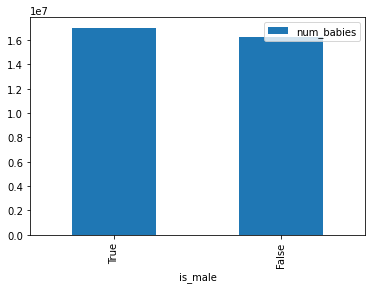

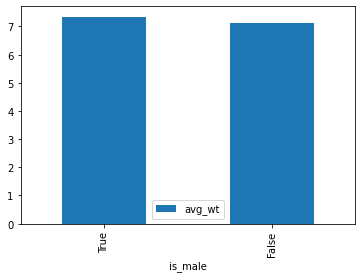

In [9]:
# is_male's influence
df.plot(x = 'is_male', y = 'num_babies', kind = 'bar');
df.plot(x = 'is_male', y = 'avg_wt', kind = 'bar');

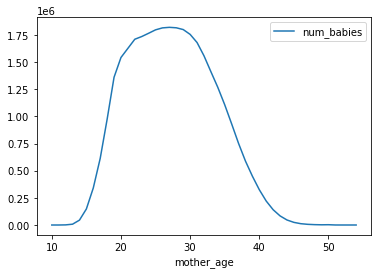

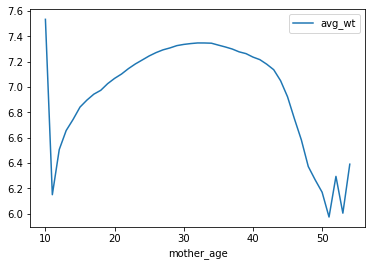

In [10]:
# Mother's age influence

df = get_distinct_values('mother_age')
df = df.sort_values('mother_age')
df.plot(x = 'mother_age', y = 'num_babies')
df.plot(x = 'mother_age', y ='avg_wt')

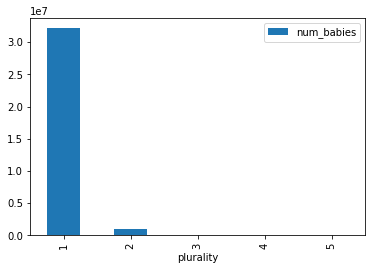

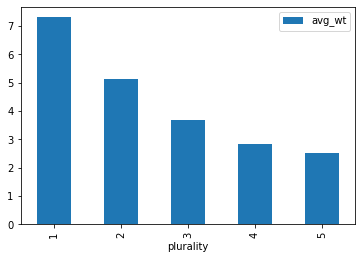

In [11]:
# Babies at birth's influence

df = get_distinct_values('plurality')
df = df.sort_values('plurality')
df.plot(x = 'plurality', y = 'num_babies', logy = True, kind = 'bar')
df.plot(x = 'plurality', y = 'avg_wt', kind = 'bar')

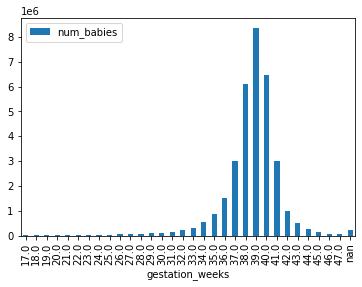

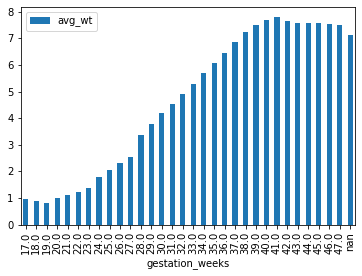

In [12]:
df = get_distinct_values('gestation_weeks')
df = df.sort_values('gestation_weeks')
df.plot(x = 'gestation_weeks', y ='num_babies', logy = True, kind = 'bar')
df.plot(x = 'gestation_weeks', y = 'avg_wt', kind = 'bar')